In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import time
import json
import matplotlib.pyplot as plt
from co_helper import *
import datetime
import torch.optim as optim
import requests

%matplotlib inline

In [2]:
df = pd.read_csv("./data/features/co19-data.csv")
df.info()
df.sort_values(by="PROVINCE_STATE_NAME").head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959926 entries, 0 to 959925
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   PEOPLE_POSITIVE_CASES_COUNT      959926 non-null  int64  
 1   COUNTY_NAME                      895706 non-null  object 
 2   PROVINCE_STATE_NAME              899542 non-null  object 
 3   REPORT_DATE                      959926 non-null  object 
 4   CONTINENT_NAME                   959926 non-null  object 
 5   DATA_SOURCE_NAME                 959926 non-null  object 
 6   PEOPLE_DEATH_NEW_COUNT           959926 non-null  int64  
 7   COUNTY_FIPS_NUMBER               880910 non-null  float64
 8   COUNTRY_ALPHA_3_CODE             959926 non-null  object 
 9   COUNTRY_SHORT_NAME               959926 non-null  object 
 10  COUNTRY_ALPHA_2_CODE             959630 non-null  object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  959926 non-null  int64  
 12  PE

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
132785,8560,Montgomery,Alabama,2020-09-17,America,New York Times,0,1101.0,USA,United States,US,14,170
237211,400,Macon,Alabama,2020-08-24,America,New York Times,0,1087.0,USA,United States,US,5,17
237212,0,Macon,Alabama,2020-03-09,America,New York Times,0,1087.0,USA,United States,US,0,0
237213,466,Macon,Alabama,2020-09-17,America,New York Times,0,1087.0,USA,United States,US,0,19
237214,40,Macon,Alabama,2020-05-03,America,New York Times,0,1087.0,USA,United States,US,2,2
132192,958,Limestone,Alabama,2020-07-23,America,New York Times,0,1083.0,USA,United States,US,18,8
132193,377,Monroe,Alabama,2020-07-23,America,New York Times,0,1099.0,USA,United States,US,18,4
132194,5499,Montgomery,Alabama,2020-07-23,America,New York Times,3,1101.0,USA,United States,US,102,133
132195,357,Randolph,Alabama,2020-07-23,America,New York Times,0,1111.0,USA,United States,US,10,11
132196,249,Washington,Alabama,2020-07-23,America,New York Times,0,1129.0,USA,United States,US,11,9


__Feature Details__:

* Numerical: 
    * PEOPLE_POSITIVE_CASES_COUNT (numerical) -  Total positive cases
    * PEOPLE_POSITIVE_NEW_CASES_COUNT (numerical) - Daily new positive cases
    * PEOPLE_DEATH_COUNT (numerical) - Total deaths
    * PEOPLE_DEATH_NEW_COUNT (numerical) - Daily new deaths counts
* Categorical:
    * REPORT_DATE (datetime/categorical) - "2020-07-23", extract categorical date encodings
    * COUNTRY_SHORT_NAME (categorical) - "United States"
    * COUNTRY_ALPHA_3_CODE (categorical) - "USA"
    * COUNTRY_ALPHA_2_CODE (categorical) - "US"
    * CONTINENT_NAME (categorical) - "America", column may not needed upon exploration
    * PROVINCE_STATE_NAME (categorical) - "Alabama"
    * COUNTY_NAME (categorical) - "Montgomery"
    * COUNTY_FIPS_NUMBER (categorical) - numerical value of COUNTY_NAME
    * DATA_SOURCE_NAME (categorical) - "New York Times" may not need upon exploration
    
    
For the purpose of this study, I will extract only the US state rows. To do that, I am going to select the `COUNTRY_SHORT_NAME` column and filter `United States`.

### Import Target Dataset

Now, a sample of target data. Each csv file is daily updates on info regarding "reopening" during this time in US states. 

For our purpose, we will only extract columns needed for target (and some features)

In [3]:
# First day sample of target data
target_samp = pd.read_csv('./data/targets/0504.csv')
target_samp.info()
target_samp.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   state_abbreviation  51 non-null     object
 1   status              51 non-null     object
 2   state               51 non-null     object
 3   date_details        51 non-null     object
 4   status_details      32 non-null     object
 5   external_link       50 non-null     object
 6   reopened            36 non-null     object
 7   reopening_soon      5 non-null      object
 8   population          51 non-null     int64 
dtypes: int64(1), object(8)
memory usage: 3.7+ KB


,state_abbreviation,status,state,date_details,status_details,external_link,reopened,reopening_soon,population
0,AL,reopening,Alabama,Stay at home began on April 4 and expired on A...,"Gov. Kay Ivey, a Republican, allowed the state...",https://www.al.com/news/2020/04/gov-kay-ivey-p...,"Outdoor and recreation - Beaches, Retail and b...",NaN,4903185
1,AK,reopening,Alaska,Stay at home in effect since March 28.,"Gov. Mike Dunleavy, a Republican, eased restri...",https://www.adn.com/alaska-news/2020/04/25/wha...,"Food and drink - Restaurant dining, Retail and...",NaN,731545
2,AZ,shutdown-restricted,Arizona,Stay at home in effect since March 31 and set ...,"Gov. Doug Ducey, a Republican, extended the st...",https://www.azcentral.com/story/news/local/ari...,Retail and beauty - Retail stores open to curb...,Retail and beauty - Retail stores open to in-p...,7278717
3,AR,soon,Arkansas,"No stay-at-home order statewide, but other res...","Gov. Asa Hutchinson, a Republican, announced t...",https://www.baxterbulletin.com/story/news/loca...,Outdoor and recreation - State park camping; Gyms,"Retail and beauty - Hair salons, barbershops, ...",3017804
4,CA,shutdown-restricted,California,Stay at home in effect since March 19.,California was the first state in the nation t...,https://www.nytimes.com/2020/04/29/us/californ...,NaN,NaN,39512223


We can see that most columns are unnecessary for our case, except for:

__Target data:__
* `state`
* `status` - `reopened`, `reopening`, `reversing`, `pausing` (convert them to ranks)
* `date_details` - Don't need this column for training purpose, but want to assess the first `closed` date referenced in the very first target data (`may 5th`)

__Extra Feature data__:
* `opened_outdoor_recreation`
* `opened_food_and_drink`
* `opened_retail`
* `opened_houses_of_worship`
* `opened_personal_care`
* `opened_entertainment`
* `population` (normalize)


Before we start assessing, I will use couple of my own functions in the `co_helper` module. 

> * `get_numerical` - Creates a new column with summed values of specified numerical columns, which in this case are any public settings that are `reopened`. Also, drop summed columns



In [4]:
# Target data file path
file_path = './data/targets/'

# Column lists from target dataset
ycols = ['state', 'status',  'date_details', 'population']
xcol = 'opened'

# Use the helper module to create a new target dataframe for weekly updates
data_y = pd.concat(get_numerical(file_path, xcol, ycols), axis=0)

In [5]:
data_y.info()
data_y.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1298 entries, (0, 0) to (24, 51)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   total_open    1298 non-null   int64 
 1   state         1298 non-null   object
 2   status        1298 non-null   object
 3   date_details  1298 non-null   object
 4   population    1298 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 56.4+ KB


total_open       state               status  \
0 0           2     Alabama            reopening   
  1           5      Alaska            reopening   
  2           1     Arizona  shutdown-restricted   
  3           2    Arkansas                 soon   
  4           0  California  shutdown-restricted   

                                          date_details  population  
0 0  Stay at home began on April 4 and expired on A...     4903185  
  1             Stay at home in effect since March 28.      731545  
  2  Stay at home in effect since March 31 and set ...     7278717  
  3  No stay-at-home order statewide, but other res...     3017804  
  4             Stay at home in effect since March 19.    39512223

## Convert Data Types and Column Names


### Feature Data

In [6]:
# 1. Filter only U.S. States via `PROVINCE_STATE_NAME` == `United States`; save as `us` 
df.columns = df.columns.str.lower()
us = df.query("country_short_name == 'United States'")

# 2. Rename columns -> lower-case and truncate, so that it's easily accessible
us.columns = df.columns.map(lambda x: x.replace(x, 'state') if x.startswith('pro') else
                            x[x.find('_')+1:] if x.startswith('p') else x)

print(us.columns)

Index(['positive_cases_count', 'county_name', 'state', 'report_date',
       'continent_name', 'data_source_name', 'death_new_count',
       'county_fips_number', 'country_alpha_3_code', 'country_short_name',
       'country_alpha_2_code', 'positive_new_cases_count', 'death_count'],
      dtype='object')


In [7]:
# 3. Convert to datetime values
dates = us.loc[:, 'report_date']
us.query("index == @dates.index")['report_date'] = dates.astype('datetime64')

I will extract dates starting from April 21th to most recently reported date in the feature set, because:

    1. Target data begins from May 4th
    2. Acceptable approximation of when the pandemic started to impact in US
    3. We will lose another week worth of data when we shift 7 days for prediction training, and thus the two week extension will balance that data loss

In [8]:
# From feature dataset, filter from April 21st
us = us.loc[us.report_date >= '2020-04-20']
us.info()
us.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601496 entries, 64011 to 959925
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   positive_cases_count      601496 non-null  int64  
 1   county_name               601496 non-null  object 
 2   state                     601496 non-null  object 
 3   report_date               601496 non-null  object 
 4   continent_name            601496 non-null  object 
 5   data_source_name          601496 non-null  object 
 6   death_new_count           601496 non-null  int64  
 7   county_fips_number        591560 non-null  float64
 8   country_alpha_3_code      601496 non-null  object 
 9   country_short_name        601496 non-null  object 
 10  country_alpha_2_code      601496 non-null  object 
 11  positive_new_cases_count  601496 non-null  int64  
 12  death_count               601496 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memor

,positive_cases_count,county_name,state,report_date,continent_name,data_source_name,death_new_count,county_fips_number,country_alpha_3_code,country_short_name,country_alpha_2_code,positive_new_cases_count,death_count
64011,160,Ozaukee,Wisconsin,2020-05-30,America,New York Times,0,55089.0,USA,United States,US,1,11
64014,1480,Ozaukee,Wisconsin,2020-09-29,America,New York Times,0,55089.0,USA,United States,US,30,19
64015,95,Ozaukee,Wisconsin,2020-05-06,America,New York Times,0,55089.0,USA,United States,US,0,9
64017,2471,Barrow,Georgia,2020-10-17,America,New York Times,3,13013.0,USA,United States,US,18,50
64018,1250,Barrow,Georgia,2020-08-07,America,New York Times,0,13013.0,USA,United States,US,36,32


## Check Missing Data

### Feature Data

I'm going to drop columns with `alpha` codes, `country_short_name`, `data_source_name`, and `continent_name`.
I won't need some of those columns for the purpose of this project, as well as couple of them are redundantly categorizing the data (ie. `USA`, `US`, `United States`, etc.). First, I will glance over missing data.



In [9]:
us.isnull().sum()

positive_cases_count           0
county_name                    0
state                          0
report_date                    0
continent_name                 0
data_source_name               0
death_new_count                0
county_fips_number          9936
country_alpha_3_code           0
country_short_name             0
country_alpha_2_code           0
positive_new_cases_count       0
death_count                    0
dtype: int64

In [10]:
# Drop columns in feature set
us = us.drop(['country_alpha_3_code', 'country_short_name', 'country_alpha_2_code', 
        'continent_name', 'data_source_name'], axis=1)

In [11]:
# State names -> compare in both datasets, then drop/add any
print("State names missing in target dataset:\n", 
      [state for state in us.state.unique() 
       if state not in data_y.state.unique()])

print("State names missing in feature dataset:\n", 
      [state for state in data_y.state.unique() 
       if state not in us.state.unique()])

print("\nState name count in feature dataset: ", len(us.state.unique()))
print("State name count in target dataset: ", len(data_y.state.unique()))

State names missing in target dataset:
 ['Northern Mariana Islands', 'Guam', 'Virgin Islands']
State names missing in feature dataset:
 []

State name count in feature dataset:  55
State name count in target dataset:  52


We can see that those three Island regions of US do not appear in the target data. They could be outliers too, so it might be better to drop them. 

I am going to check state name value counts in both datasets.

In [12]:
print(np.hstack(data_y.state.value_counts()))
print(np.hstack(us.state.value_counts()))

[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 23]
[46736 29440 24656 22264 21712 19504 18952 18400 18400 17664 17296 17112
 16376 16192 15456 15272 14536 14352 13984 13432 12512 12512 12328 12328
 11960 11960 10856 10856 10488 10304  9936  8648  8280  7360  6624  6256
  5520  5152  4600  4416  4048  3128  3128  2944  2760  2760  2024  1656
  1104   920   736   736   552   184   184]


One thing is that, the value counts in feature data does not matter, since they are representing counties as well in each state. However, we need to find the state that is missing in one of the reported date in target set.

In [13]:
data_y.state.value_counts().sort_values().iloc[:1]

Puerto Rico    23
Name: state, dtype: int64

In [14]:
'Puerto Rico' in us.state.unique()

True

I am going to drop `Puerto Rico`, considering the region to be in the same type of category as the other island/outlier regions.

In [15]:
data_y = data_y.query("state != 'Puerto Rico'")
us = us.query("state != 'Puerto Rico'")

In [16]:
# Drop the other 3 islands from the feature dataset
us = us.query("state in @data_y.state.unique()")

In [17]:
print(data_y.state.nunique() == us.state.nunique())


True


Now I am going to fill in nulls for `county_fips_number` column by grouping the counties in the order of `death_counts` and `

In [18]:
# First, find the counties with missing 'fips' number
us.query("county_fips_number.isnull()").head()

# STOPPED HERE: QUERY WITH ORIGINAL DATA, ON THE INDICES OF BELOW CODE TO FILL NA
fill_idx = us.sort_values(by=['report_date', 'state', 'positive_cases_count', 
            'positive_new_cases_count']).fillna(method='pad')
us.loc[fill_idx.index, 'county_fips_number'] = fill_idx.loc[:, 'county_fips_number']



In [19]:
us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585488 entries, 64011 to 959925
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   positive_cases_count      585488 non-null  int64  
 1   county_name               585488 non-null  object 
 2   state                     585488 non-null  object 
 3   report_date               585488 non-null  object 
 4   death_new_count           585488 non-null  int64  
 5   county_fips_number        585488 non-null  float64
 6   positive_new_cases_count  585488 non-null  int64  
 7   death_count               585488 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 60.2+ MB


### Target Data

Only thing I need to do for target in this section is to drop `date_details` column. But there are some important data transformation to do in this dataset, which I will be doing next section.

In [20]:
data_y = data_y.drop('date_details', axis=1)

# Data/Feature Transformation

- [x] Add date column in the target data (weekly)
- [x] Aggregate counties numerical data by averaging weekly
- [x] Combine features: proportions of cases/death counts to population
- [x] `status` and `total open` columns merge with feature dataset
- [x] Convert `status` to numerical integer masks

### Prep for Data Merge

In [21]:
# 1. Add date column in target data
start_date = datetime.date(2020, 5, 4)
end_date = datetime.date(2020, 10, 19)

nskip = len(data_y.index.unique()) # 51 rows to skip

# Get list of dates to fill in
week_dates = [(start_date + datetime.timedelta(n)).strftime('%Y-%m-%d')
             for n in range(0, int((end_date - start_date).days)+7, 7)]
print(len(week_dates))


25


In [22]:
data_y = data_y.reset_index()


In [23]:
for name in data_y.state.unique():
    data_y.loc[data_y.state==name, 'report_date'] = week_dates

In [24]:
data_y.head()

,level_0,level_1,total_open,state,status,population,report_date
0,0,0,2,Alabama,reopening,4903185,2020-05-04
1,0,1,5,Alaska,reopening,731545,2020-05-04
2,0,2,1,Arizona,shutdown-restricted,7278717,2020-05-04
3,0,3,2,Arkansas,soon,3017804,2020-05-04
4,0,4,0,California,shutdown-restricted,39512223,2020-05-04


In [25]:
us.head()

,positive_cases_count,county_name,state,report_date,death_new_count,county_fips_number,positive_new_cases_count,death_count
64011,160,Ozaukee,Wisconsin,2020-05-30,0,55089.0,1,11
64014,1480,Ozaukee,Wisconsin,2020-09-29,0,55089.0,30,19
64015,95,Ozaukee,Wisconsin,2020-05-06,0,55089.0,0,9
64017,2471,Barrow,Georgia,2020-10-17,3,13013.0,18,50
64018,1250,Barrow,Georgia,2020-08-07,0,13013.0,36,32


In [26]:
# 2. Aggregate feature data by county mean
numerical_cols = ['positive_new_cases_count', 'positive_cases_count',
                  'death_new_count', 'death_count']
us = us.sort_values(by=['state', 'county_fips_number','report_date'])
weekly = us.set_index(pd.to_datetime(us['report_date'])).groupby(['state','county_fips_number'])[numerical_cols].resample('7D').mean()


In [27]:
data_y.report_date = data_y.report_date.astype('datetime64')

In [28]:
# 3. Move `total open` and `population` columns to feature dataset

data_x = weekly.reset_index().merge(data_y, how='left', on=['report_date', 'state']).fillna(method='bfill')
data_x.head()

,state,county_fips_number,report_date,positive_new_cases_count,positive_cases_count,death_new_count,death_count,level_0,level_1,total_open,status,population
0,Alabama,1001.0,2020-04-20,1.428571,33.285714,0.000000,1.714286,0.0,0.0,2.0,reopening,4903185.0
1,Alabama,1001.0,2020-04-27,1.571429,42.714286,0.142857,3.428571,0.0,0.0,2.0,reopening,4903185.0
2,Alabama,1001.0,2020-05-04,3.714286,62.000000,0.142857,3.428571,0.0,0.0,2.0,reopening,4903185.0
3,Alabama,1001.0,2020-05-11,5.142857,99.285714,0.000000,4.000000,1.0,0.0,2.0,reopening,4903185.0
4,Alabama,1001.0,2020-05-18,7.000000,141.857143,-0.142857,3.285714,2.0,1.0,6.0,reopening,4903185.0


In [29]:
data_x

,state,county_fips_number,report_date,positive_new_cases_count,positive_cases_count,death_new_count,death_count,level_0,level_1,total_open,status,population
0,Alabama,1001.0,2020-04-20,1.428571,33.285714,0.000000,1.714286,0.0,0.0,2.0,reopening,4903185.0
1,Alabama,1001.0,2020-04-27,1.571429,42.714286,0.142857,3.428571,0.0,0.0,2.0,reopening,4903185.0
2,Alabama,1001.0,2020-05-04,3.714286,62.000000,0.142857,3.428571,0.0,0.0,2.0,reopening,4903185.0
3,Alabama,1001.0,2020-05-11,5.142857,99.285714,0.000000,4.000000,1.0,0.0,2.0,reopening,4903185.0
4,Alabama,1001.0,2020-05-18,7.000000,141.857143,-0.142857,3.285714,2.0,1.0,6.0,reopening,4903185.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85431,Wyoming,56045.0,2020-09-21,1.857143,29.714286,0.000000,0.000000,20.0,51.0,13.0,reopened,578759.0
85432,Wyoming,56045.0,2020-09-28,0.857143,39.000000,0.000000,0.000000,21.0,51.0,13.0,reopened,578759.0
85433,Wyoming,56045.0,2020-10-05,2.285714,51.571429,0.000000,0.000000,22.0,51.0,13.0,reopened,578759.0
85434,Wyoming,56045.0,2020-10-12,5.000000,74.142857,0.000000,0.000000,23.0,51.0,13.0,reopened,578759.0


### Dummy Values

Next, I will convert all categorical string values to their dummy masks, so that I can continue with any further analysis using just number values.

__Target Conversion Details:__

* `reopened`|`0`  -> encompasses `reopened`, `forward`; "safe to travel outdoors", "dining in", "gyms open", "salons open", "enclosed entertainment settings potential", "OK to work in office settings", etc.

* `in risk`|`1`  -> encompasses `reopening`, `pausing`, `regional`, `soon`; anything in between "all OK to open" and "all closed".

* `closed`|`2`  -> encompasses `reversing`, `shutdown-restricted`; "all closed", "in danger", "stay home", "no gyms".

[COVID-19 United States Reopen and Shut Down Status by State](https://github.com/rearc-data/nyt-states-reopen-status-covid-19)



In [30]:
# ===== Target variable ===== #
status_d = {0: ['reopened', 'forward'],
            1: ['reopening', 'pausing', 'regional', 'soon'],
            2: ['reversing', 'shutdown-restricted']}

mask = 1

data_x.status = data_x.status.apply(lambda x: mask-1 if x in status_d[mask-1] 
                                                   else (mask+1 if x in status_d[mask+1]
                                                         else mask))
# ===== Feature categorical variables ===== #

# Convert `state` values to integer id
state_dict = {data_x.state.unique()[ii]:ii+1 for ii in range(len(data_x.state.unique()))}
data_x['state_dummy'] = [state_dict[state_key] for state_key in data_x.loc[:, 'state']]

# Get month and week number features from 'report_date'
dates_col = data_x.loc[:,'report_date']
data_x['month'] = pd.to_datetime(dates_col).dt.month

# Convert month values into string names
#data_x['month'] = data_x['month'].map(lambda x: datetime.date(1900, x, 1).strftime('%B')).values
data_x['week'] = pd.to_datetime(dates_col).dt.isocalendar().week.values

### Assessment and More Transformation

- [x] Feature interactions and morphing
- [x] Check stationarity
- [x] Scale continuous variables
- [x] Linear Regression Coefficents & PCA

__1. Assess feature interactions and morph__

- by aggregating state's/counties'/weekly counts and population mean
- get proportions, percentages and feature interactions(`Sklearn PolynomialFeatures`)
- scale `population` and other numerical features that seems skewed 

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Initialize polynomial feature extractor, scaler and logistic regression
std_scaler = StandardScaler()
lreg = LinearRegression()
polyfit_2 = PolynomialFeatures(degree=2,interaction_only=True)

Before I scale the numerical values, I am going to create couple new features derived from original numerical features.

In [32]:
# get sample target data population column
population = dict(target_samp.set_index('state')['population'])
uniq_county_cnt = dict(data_x.groupby('state').county_fips_number.nunique())
pop_portion = {key: round(population[key]/uniq_county_cnt[key], 4) for key in population.keys()}

''' ### IGNORE 
county_count = data_x.county_fips_number.value_counts()
state_count = data_x.state.value_counts()
data_x.query("state in @state_count.index").set_index('state')['population']/state_count
### '''

data_x['pop_portion'] = 0.0
data_x.loc[:, 'pop_portion'] = [pop_portion[state_name] for state_name in data_x.loc[:, 'state']]

In [33]:
# New column for weekly summed cases counts and death counts
data_x['total_count'] = np.sum(data_x[['positive_cases_count', 'death_count']], axis=1)

# Sum those totals by each state weekly
state_total_cnt = data_x.groupby(['report_date','state'])[['total_count']].agg(np.sum)

# Merge that column into original
data_x_temp = data_x.merge(state_total_cnt.reset_index(), how='left', on=['report_date', 'state'])

In [34]:
# Get counties' total weekly counts portion to state weekly total counts
data_x['total_weekly_portion'] = round(data_x_temp['total_count_x']/(data_x_temp['total_count_y']+0.01), 4)

In [35]:
# Get counties' weekly interactions between total weekly count portion and their average state population 
data_x['wk_portion_to_avg_pop'] = polyfit_2.fit_transform(data_x[['total_weekly_portion', 'pop_portion']])[:, -1]
data_x.head()

,state,county_fips_number,report_date,positive_new_cases_count,positive_cases_count,death_new_count,death_count,level_0,level_1,total_open,status,population,state_dummy,month,week,pop_portion,total_count,total_weekly_portion,wk_portion_to_avg_pop
0,Alabama,1001.0,2020-04-20,1.428571,33.285714,0.000000,1.714286,0.0,0.0,2.0,1,4903185.0,1,4,17,73181.8657,35.000000,0.0058,424.454821
1,Alabama,1001.0,2020-04-27,1.571429,42.714286,0.142857,3.428571,0.0,0.0,2.0,1,4903185.0,1,4,18,73181.8657,46.142857,0.0062,453.727567
2,Alabama,1001.0,2020-05-04,3.714286,62.000000,0.142857,3.428571,0.0,0.0,2.0,1,4903185.0,1,5,19,73181.8657,65.428571,0.0070,512.273060
3,Alabama,1001.0,2020-05-11,5.142857,99.285714,0.000000,4.000000,1.0,0.0,2.0,1,4903185.0,1,5,20,73181.8657,103.285714,0.0090,658.636791
4,Alabama,1001.0,2020-05-18,7.000000,141.857143,-0.142857,3.285714,2.0,1.0,6.0,1,4903185.0,1,5,21,73181.8657,145.142857,0.0105,768.409590


In [36]:
# Get counties' weekly case/death portions morphed with state weekly 'total_open' 
data_x['weekly_open_portion'] = polyfit_2.fit_transform(data_x[['total_open', 'total_weekly_portion']])[:, -1]

In [37]:
# Transform all weekly portions of counts to percentage
data_x[['total_weekly_portion', 'weekly_open_portion']] = data_x.loc[:, ['total_weekly_portion', 'weekly_open_portion']].mul(100)

In [38]:
data_x.info()
data_x.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85436 entries, 0 to 85435
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   state                     85436 non-null  object        
 1   county_fips_number        85436 non-null  float64       
 2   report_date               85436 non-null  datetime64[ns]
 3   positive_new_cases_count  85436 non-null  float64       
 4   positive_cases_count      85436 non-null  float64       
 5   death_new_count           85436 non-null  float64       
 6   death_count               85436 non-null  float64       
 7   level_0                   85436 non-null  float64       
 8   level_1                   85436 non-null  float64       
 9   total_open                85436 non-null  float64       
 10  status                    85436 non-null  int64         
 11  population                85436 non-null  float64       
 12  state_dummy       

,state,county_fips_number,report_date,positive_new_cases_count,positive_cases_count,death_new_count,death_count,level_0,level_1,total_open,status,population,state_dummy,month,week,pop_portion,total_count,total_weekly_portion,wk_portion_to_avg_pop,weekly_open_portion
0,Alabama,1001.0,2020-04-20,1.428571,33.285714,0.000000,1.714286,0.0,0.0,2.0,1,4903185.0,1,4,17,73181.8657,35.000000,0.58,424.454821,1.16
1,Alabama,1001.0,2020-04-27,1.571429,42.714286,0.142857,3.428571,0.0,0.0,2.0,1,4903185.0,1,4,18,73181.8657,46.142857,0.62,453.727567,1.24
2,Alabama,1001.0,2020-05-04,3.714286,62.000000,0.142857,3.428571,0.0,0.0,2.0,1,4903185.0,1,5,19,73181.8657,65.428571,0.70,512.273060,1.40
3,Alabama,1001.0,2020-05-11,5.142857,99.285714,0.000000,4.000000,1.0,0.0,2.0,1,4903185.0,1,5,20,73181.8657,103.285714,0.90,658.636791,1.80
4,Alabama,1001.0,2020-05-18,7.000000,141.857143,-0.142857,3.285714,2.0,1.0,6.0,1,4903185.0,1,5,21,73181.8657,145.142857,1.05,768.409590,6.30


__2. Check stationarity and plot stats__


In [39]:
# ADF stationary test
from statsmodels.tsa.stattools import adfuller

def adf_test(ts):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfout = pd.Series(dftest[0:4], 
                      index=['Test Statistic','p-value',
                             '#Lags Used','Number of Observations Used'])
    for key, val in dftest[4].items():
        dfout['Critical Value (%s)'%key] = val
    print (dfout)

# Quick look at `positive_cases_count` stationarity 
adf_test(data_x.groupby('state')['positive_cases_count'].agg(np.mean))

Results of Dickey-Fuller Test:
Test Statistic                -6.322548e+00
p-value                        3.041092e-08
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64


[ADF test function](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)

Stationarity checking for timeseries data should also be assessed on our weekly aggregated mean values, so that we are able to see whether timely trends have been mediated or not. I only checked `positive_cases_count`, since other original numerical feature aggregates probably correspond to the trend changes similar to that column. Also, counts of Covid-19 cases seems more robust way of measuring the spread of the virus, compared to number of deaths (and all other "morphed" columns derive from those two columns). `Test Statistics` of the ADF stationarity test indicates that those values are most likely to be stationary.



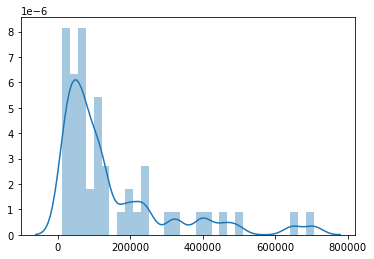

/Users/jmaclvin/anaconda3/envs/dsbase/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


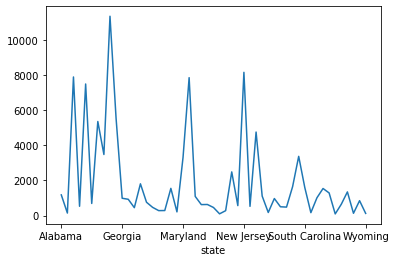

In [40]:
# Scale unevenly distributed features
#data_x.groupby('state')['population'].plot()

sns.distplot(pd.DataFrame(pop_portion, index=population.keys()), label='Avg Population by State Distribution')
plt.show()

# Plot timeline
data_x.groupby('state')['positive_cases_count'].agg(np.mean).plot()
plt.show()

Just looking at the distribution plot for `population` of each state, we can assume that rest of the numerical columns amalgamated with that column will be skewed as well. For best optimization of our machine, it is important to standardize each of those numerical columns. Before I apply Sklearn's `StandardScaler`, I will hold off each state's last couple weeks to save 20% for test dataset.

,county_fips_number,positive_new_cases_count,positive_cases_count,death_new_count,death_count,total_open,status,population,state_dummy,month,week,pop_portion,total_count,total_weekly_portion,wk_portion_to_avg_pop,weekly_open_portion
county_fips_number,1.000000e+00,-0.049014,-0.049329,-0.037341,-0.027922,0.022931,-0.086345,0.103115,0.999407,-0.000006,-8.826965e-07,-0.159058,-0.048822,-0.027326,-0.062864,-0.025056
positive_new_cases_count,-4.901393e-02,1.000000,0.666688,0.624736,0.422702,0.039499,0.083414,0.144147,-0.047876,0.044054,4.534849e-02,0.201243,0.661775,0.302257,0.319780,0.355841
positive_cases_count,-4.932852e-02,0.666688,1.000000,0.505381,0.798743,0.084016,0.062661,0.137822,-0.047896,0.109873,1.115038e-01,0.233347,0.999669,0.343672,0.379589,0.481403
death_new_count,-3.734101e-02,0.624736,0.505381,1.000000,0.460632,-0.021575,0.092414,0.094843,-0.036408,-0.032148,-3.185863e-02,0.185232,0.507648,0.267776,0.303165,0.216131
death_count,-2.792203e-02,0.422702,0.798743,0.460632,1.000000,0.067715,0.042741,0.078431,-0.026836,0.051167,5.179549e-02,0.207731,0.813950,0.322249,0.366138,0.452631
total_open,2.293096e-02,0.039499,0.084016,-0.021575,0.067715,1.000000,0.015482,0.225859,0.017235,0.573029,5.611914e-01,0.080892,0.084014,-0.047280,-0.022816,0.135245
status,-8.634455e-02,0.083414,0.062661,0.092414,0.042741,0.015482,1.000000,0.422049,-0.086589,-0.282700,-2.923875e-01,0.318690,0.062328,0.034506,0.068359,-0.010202
population,1.031146e-01,0.144147,0.137822,0.094843,0.078431,0.225859,0.422049,1.000000,0.106848,0.000321,4.759463e-04,0.612396,0.136424,-0.081215,0.003771,-0.063178
state_dummy,9.994067e-01,-0.047876,-0.047896,-0.036408,-0.026836,0.017235,-0.086589,0.106848,1.000000,0.000067,4.552725e-05,-0.150915,-0.047392,-0.025057,-0.060913,-0.024786
month,-5.548403e-06,0.044054,0.109873,-0.032148,0.051167,0.573029,-0.282700,0.000321,0.000067,1.000000,9.872986e-01,0.000785,0.108273,0.008672,0.003815,0.094092


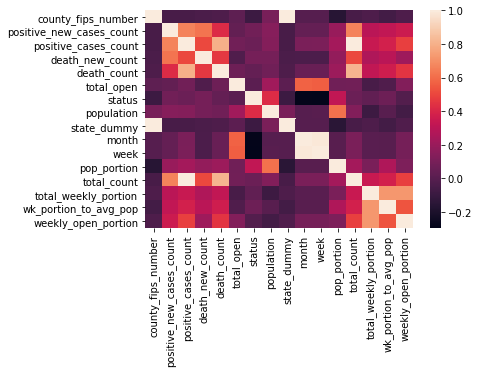

In [41]:
data_x = data_x.set_index('state').drop(['level_0', 'level_1'], axis=1)
sns.heatmap(data_x.corr())
data_x.corr()

__3. Scale continuous variables__

First split into train set and test set

In [42]:
# Get the cut off date for train set
date_list = sorted(data_x.report_date.unique())
date_list[:int(len(date_list)*.8)][-1]

numpy.datetime64('2020-09-15T00:00:00.000000000')

In [43]:
# Split into train and test set
train_feats = data_x.loc[data_x.report_date <= '2020-09-15'].drop('status', axis=1)
test_feats = data_x.query("report_date not in @train_feats.report_date").drop('status', axis=1)

# Save target data as well
train_y = data_x.query("report_date in @train_feats.report_date")[['status', 
                                                                   'report_date', 
                                                                   'county_fips_number']].set_index(['report_date',
                                                                                                     'county_fips_number'])

test_y = data_x.query("report_date in @test_feats.report_date")[['status', 
                                                                 'report_date', 
                                                                 'county_fips_number']].set_index(['report_date',
                                                                                                  'county_fips_number'])

# Extract only columns to scale
scale_cols = train_feats.drop(['state_dummy', 'report_date', 'month',
                                  'county_fips_number', 'week'], axis=1)
# Fit and transform using standard scaler
scaled_X = std_scaler.fit_transform(scale_cols.astype(float))
# Substitute scaled values into extracted df
scale_cols.loc[:, scale_cols.columns] = scaled_X
# Concatenate other feature train columns with above df
X_sc = pd.concat([train_feats.loc[:, [cols for cols in train_feats.columns if cols not in scale_cols.columns]],
                  scale_cols], axis=1)


In [44]:
# Resetting index keys
X_sc = X_sc.reset_index('state', drop=True).set_index('report_date')
train_feats = train_feats.reset_index('state', drop=True).set_index('report_date')
test_feats = test_feats.reset_index('state', drop=True).set_index('report_date')

__4. Evaluate feature relations, assess ways to morph features, and perform statistical analysis__

In [47]:
# -- MSE, Linear Regression coeffs, and PCA

# must take absolute value because sklearn makes the errors negative
mean_squared_errors = np.abs(cross_val_score(lreg, X_sc.values,
                                             train_y.squeeze(), cv=50, scoring='neg_mean_squared_error'))
root_mean_squared_errors = list(map(np.sqrt, mean_squared_errors))
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
pd.set_option('precision', 4)

50-fold mean RMSE:  0.553172337650339


Trying out different `cv` param values on `X_sc` dataset:

    `10-fold mean RMSE:  0.5942417340887484`
    `50-fold mean RMSE:  0.553172337650339`
    
The root mean squared error implies that using our current features, we will be off by .5 (need to check this assumption).

Below are the coefficients of feature variables; how much impact it has on the lin regression

In [48]:
coeffs = LinearRegression().fit(X_sc.values,train_y.squeeze()).coef_
coeff_df = pd.DataFrame(list(zip(X_sc.columns,np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
coeff_df

,features,betas
9,population,2.0170e-01
2,month,9.5967e-02
1,state_dummy,9.1724e-02
8,total_open,7.9370e-02
10,pop_portion,7.2495e-02
12,total_weekly_portion,6.4852e-02
3,week,5.6052e-02
7,death_count,4.2913e-02
14,weekly_open_portion,4.1503e-02
5,positive_cases_count,2.8487e-02



Now moving on to __PCA__, [Principal Components Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis): 

> * a method for transforming base features into a new feature space (re-discovering the best fit center mean within the x-y grid space, to imagine)
> * The `component` matrix below will tells us how to generate the new components and by which combinations of features
> * resulting components are ordered from most-important to least important
> * We get `eigenvectors` of each column, which references to how much variance is explained by that column
> * Reduces dimensionality and allows simpler assessments

In [49]:
pca = PCA()
#pca_tester = train_feats.drop(['county_fips_number', 'state_dummy', 'month', 'week'], axis=1)
# Fit to original unscaled train feature df
X_pca = pca.fit_transform(scale_cols)

# Create component indices
component_names = ["component_"+str(comp) 
                   for comp in range(1, len(pca.explained_variance_)+1)]

#generate new component dataframe
X_pca = pd.DataFrame(X_pca,columns=component_names)
#print(train_feats.head())
X_pca.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11
0,-0.5838,0.6126,0.4953,1.0662,-0.4039,-0.1908,0.0051,-0.0123,0.1062,0.0157,4.0524e-13
1,-0.5566,0.6088,0.5106,1.0811,-0.3721,-0.1630,0.0400,-0.0125,0.1083,0.0264,5.6324e-13
2,-0.5378,0.6103,0.5125,1.0851,-0.3552,-0.1788,0.0292,-0.0128,0.1034,0.0119,-2.6637e-15
3,-0.5327,0.6268,0.4889,1.0728,-0.3784,-0.2168,-0.0117,-0.0063,0.0839,-0.0127,3.2426e-14
4,-0.4938,0.5397,0.3699,0.6168,-0.2400,-0.1571,-0.0824,-0.0587,0.0384,-0.0419,-4.2698e-17


Looking at both the matrix and each PCA dimension

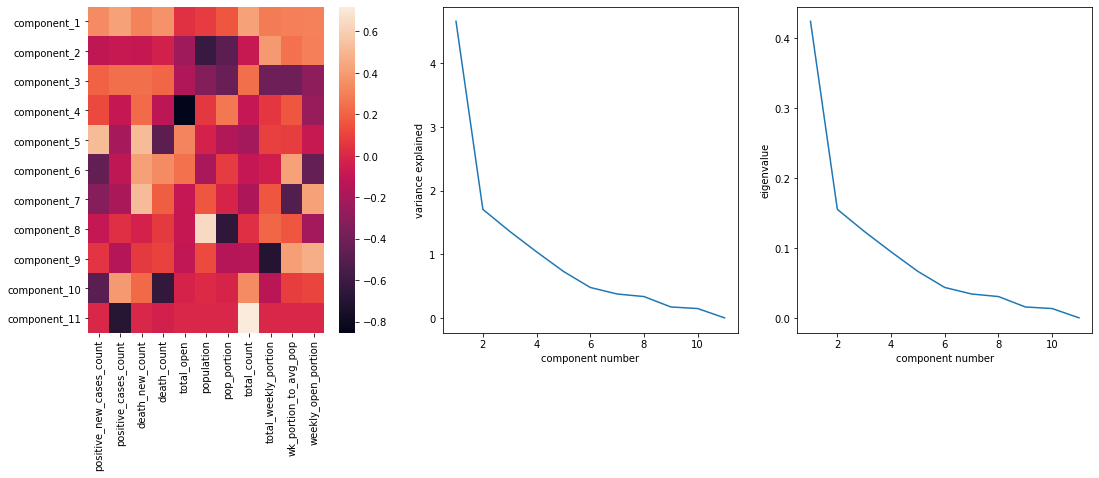

In [50]:
# Generate component loadings on original features
component_matrix = pd.DataFrame(pca.components_, index=component_names, 
                                columns=scale_cols.columns)
# Add additional columns to describe the matrix
component_matrix["explained_variance_ratio"] = pca.explained_variance_ratio_
component_matrix["eigenvalue"] = pca.explained_variance_

figure = sns.mpl.pyplot.figure(figsize=(18,6))
#add 3 subplots one at a time

#first the component matrix
figure.add_subplot(131)
sns.heatmap(component_matrix.iloc[:,:-2])

#then the eigenvalues
figure.add_subplot(132)
sns.mpl.pyplot.plot(range(1,component_matrix.shape[0]+1), component_matrix.eigenvalue)
sns.mpl.pyplot.xlabel("component number")
sns.mpl.pyplot.ylabel("variance explained")

#then the explained variance ratio
figure.add_subplot(133)
sns.mpl.pyplot.plot(range(1,component_matrix.shape[0]+1), component_matrix.explained_variance_ratio)
sns.mpl.pyplot.xlabel("component number")
sns.mpl.pyplot.ylabel("eigenvalue");

In [51]:
component_matrix.explained_variance_ratio.cumsum()

component_1     0.4238
component_2     0.5789
component_3     0.7025
component_4     0.7968
component_5     0.8632
component_6     0.9066
component_7     0.9407
component_8     0.9711
component_9     0.9867
component_10    1.0000
component_11    1.0000
Name: explained_variance_ratio, dtype: float64

Above tells us that the first 9 components explains about 98% of variance in the data. Considering that, we can try computing the RMSE again using just the first 9 features.

In [54]:
mean_squared_errors = np.abs(cross_val_score(lreg, X_pca.iloc[:,:-2], 
                                             train_y.values.squeeze(), 
                                             cv=500,scoring='neg_mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = list(map(np.sqrt,mean_squared_errors))
print("1000-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("1000-fold std RMSE: ", np.std(root_mean_squared_errors))

1000-fold mean RMSE:  0.5598550351969016
1000-fold std RMSE:  0.20419356062967356


Other values for `cv`:
    `50-fold mean RMSE:  0.5799058146797296`
    `50-fold std RMSE:  0.1701768961680871`
    
    `100-fold mean RMSE:  0.5690888784990323`
    `100-fold std RMSE:  0.1878179603975211`
    
    `500-fold mean RMSE:  0.5598550351969016`
    `500-fold std RMSE:  0.20419356062967356`

I think I will just stick to the features I have right now, since results from these are not that significantly different.

# Build Neural Network

Now to the fun part

1. But first, I need to create an `embedding_lookup` dictionary if I decide to use one.
    * Unique feature values as the dictionary values
    * keys as significance rank based on linear regression coefficient ordering. 
    * feature variable's  on the very bottom of the chart gets index value 1
    
2. Other option for a network is to build my own prototype (refer to `MNN` below)

In [85]:
''' ** IGNORE HERE ** '''
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normed_x = train_feats.copy()
normed_x.loc[:, :] = normalizer.fit_transform(train_feats)
normed_x.head()


,county_fips_number,positive_new_cases_count,positive_cases_count,death_new_count,death_count,total_open,population,state_dummy,month,week,pop_portion,total_count,total_weekly_portion,wk_portion_to_avg_pop,weekly_open_portion
report_date,,,,,,,,,,,,,,,
2020-04-20,0.0002,2.9132e-07,6.7878e-06,0.0000e+00,3.4959e-07,4.0785e-07,0.9999,2.0393e-07,8.1571e-07,3.4667e-06,0.0149,7.1374e-06,1.1828e-07,8.6558e-05,2.3655e-07
2020-04-27,0.0002,3.2046e-07,8.7106e-06,2.9132e-08,6.9918e-07,4.0785e-07,0.9999,2.0393e-07,8.1571e-07,3.6707e-06,0.0149,9.4097e-06,1.2643e-07,9.2527e-05,2.5287e-07
2020-05-04,0.0002,7.5744e-07,1.2643e-05,2.9132e-08,6.9918e-07,4.0785e-07,0.9999,2.0393e-07,1.0196e-06,3.8746e-06,0.0149,1.3343e-05,1.4275e-07,1.0447e-04,2.8550e-07
2020-05-11,0.0002,1.0488e-06,2.0247e-05,0.0000e+00,8.1571e-07,4.0785e-07,0.9999,2.0393e-07,1.0196e-06,4.0785e-06,0.0149,2.1063e-05,1.8353e-07,1.3431e-04,3.6707e-07
2020-05-18,0.0002,1.4275e-06,2.8928e-05,-2.9132e-08,6.7004e-07,1.2236e-06,0.9999,2.0393e-07,1.0196e-06,4.2825e-06,0.0149,2.9598e-05,2.1412e-07,1.5670e-04,1.2847e-06


In [114]:
''' ** IGNORE HERE ** '''
value_list = sorted(list(set(np.round_(normed_x.values, 8).reshape(1, -1).tolist()[0])), reverse=True)
id_to_val = {ii+1: value_list[ii] for ii in range(len(value_list))}
val_to_id = {val: key for key, val in id_to_val.items()}



__Network Process:__

<mark>Perceptron I</mark>

1. takes in a batch of record sequences
2. flattens the input to shape (-1, 1)
3. passes it through first fully connected layer, `fc0_in` with dimension (input_size, hidden_1_dim)
    - batchnorm, relu
    - think of the hidden_1_dim as kernel size
4. passes through `fc0_out` with size (hidden_1_dim, class_size)
    - predicts input's timestep y
    - relu, softmax

*****************************************************************************************
<mark>Enters Perceptron II: "Mirror Neuron"</mark>

    * (fc1~fc_n, where n = t-2)*
    * Comprised of multiple double-layered fc's, decoder & encoder, respectively
    * therefore "mirrors" (flips process backward) the first Perceptron's behavior, to say

__M_fc1 to M_fc_n | n = t-1__<br>
5. decoder input size (class_size, hidden_2_dim1) 
    - batchnorm, relu until final, except output is just relu and logsoftmax
    - mid layer size (hidden_2_dim1, hidden_2_dim2)
    - output layer size (hidden_2_dim2, input_size+1)
        * output is timestep 0 plus its y
    
6. passes through "residual" layers of size (input_size+1, input_size+1)
    - r layers, where r is defined in the initial parameter setting
    - helps learning by retaining the size
    - relu each layer
6. encoder layer size (input_size+1, hidden_2_dim2)
    - takes in the learned weights of size inputs plus predicted y
    - mid layer size (hidden_2_dim2, hidden_2_dim1)
    - out layer size (hidden_2_dim1, class_size)
    - batchnorms except output, and relu til the end with softmax at output
  
*****************************************************************************************
__One option in addition to the above architecture is that..__

    What if, Perceptron I concurrently predicts a y for that day of given input 
    (i.e. t = 7, so y_0 = input's date y; y_1 = next day y... y_7 = last timestep's y)
    while the mirror perceptron (perhaps using the weights of P.I. as input w/ size input+1)
    tries to encode the next day y, passing that onto its decoder thru gate layer, which then 
    the decoder takes in input of class_size and outputs a generated next day of size input+1.
    And this concurrent cycle would repeat; two Perceptrons doing different things but 
    in a reflective (pun intended) manner, utilizing and updating each other's weights until the
    final final layer (all batchnorms and relu, except all outputs for generated x get relu and 
    LogSoftmax, while all y outputs get softmax.
    
    The final layer would just be a (another) fully connected layer, that takes in the output 
    of the Mirror Perceptron's final encoder output, t timestep y, and outputs t+1 day's y.
    Its final output, y at t+1, is the main prediction we are measuring at with our error function,
    before running through back propagation with the error updated initial hidden weights.
 

In [ ]:
# Recurrent Neural Network w/ Pytorch LSTM
'''
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, 
                            dropout=pdrop, batch_first=True)
'''
class MNN(nn.Module):
    
    def __init__(self, in_size, class_size, h_size, steps=7, n_learns=8):
        '''
        Mirror Perceptrons
        ------------------
        
        Params
        ------
        class_size(int): Number of classes; applied as initial hidden layer size
        '''
        super(Co19NN, self).__init__()
        
        self.in_size = in_size              # resize to (-1, 1)
        self.out_size = in_size+class_size  # output size of each perceptron
        self.class_size = class_size        # hidden weight size (1st)
        
        # *** PERCEPTRON I *** #
        self.Pfc1 = nn.Linear(in_size, h_size, bias=False)
        #self.bn0 = nn.BatchNorm1d(self.class_size)
        self.Pfc2 = nn.Linear(h_size, class_size)
            # => Concurrent Cycle Process 1
        
        # *** PERCEPTRON II: Mirror Perceptron *** #
            # => "Generator"
        self.Mfc1 = nn.Linear(class_size, h_size, bias=False)  # "Generator"
        # self.bn1 = nn.BatchNorm1d(h_size)
        self.Mfc2 = nn.Linear(h_size, h_size*2, bias=False)    # hi_size > ho_size
        #self.bn2 = nn.BatchNorm1d(h_size*2)
        self.Mfc3 = nn.Linear(h_size*2, self.out_size)
            # => "Learn Gate"
        self.Lfc1 = nn.Linear(self.out_size, self.out_size, bias=False)  # TODO: CREATE A SEQUENCE TO REPEAT t STEPS
        #self.bn3 = nn.BatchNorm1d(self.ho_size)
            # => "Encoder"
        self.Mfc4 = nn.Linear(self.out_size, h_size*2)
        self.Mfc5 = nn.Linear(h_size*2, h_size, bias=False)
        #self.bn4 = nn.BatchNorm1d(self.class_size)
        self.Mfc6 = nn.Linear(h_size, class_size)
            # => Concurrent Cycle Process 2

        self.bn1 = nn.BatchNorm1d(class_size)
        self.bn2 = nn.BatchNorm1d(h_size)
        self.bn3 = nn.BatchNorm1d(h_size*2)
        self.bn4 = nn.BatchNorm1d(self.out_size)
        
        self.soft = nn.Softmax(dim=1)     # Applied on class_size outputs
        self.Lsoft = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        
        Params
        ------
        
        Returns
        -------
        
        """
        # ===> Passing Perceptron I (concurrent cycling t times)
        x = x.view(-1, 1)
        x = self.Pfc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.Pfc2(x)
        x = self.soft(F.relu(x))
        # ===> Passing Perceptron II (concurrent cycling t times)
        x = self.Mfc1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.Mfc2(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.Lsoft(x)
        # ---> Learn Gate (repeat Lfc to r times)
        x = self.Lfc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        # ...
        x = self.Mfc3(x)
        x = F.relu(x)
        x = self.Mfc4(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.Mfc5(x)
        x = self.soft(F.relu(x))
        
        return x
        
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        
        Params
        ------
        batch_size(int): batch_size of the hidden state
        
        Returns
        -------
        Hidden state of dimensions, (n_layers, batch_size, hidden_dim)
        '''
        # Two new tensors with sizes stated above, 
        # initialized to zero then move to GPU if available
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden
    

